### Неросеть для соотношения матрица-наполнитель

импорт необходимых модулей и библиотек


In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [169]:
# Импорт библиотеки TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.8.0


In [186]:
#  истина vs пророчества в картинках
def plot_preds(y_test, y_pred, title = ''):
    plt.subplots(figsize=(12, 5))
    plt.plot(y_pred, 'r*')
    plt.plot(y_test.reset_index(drop=True),'g.')
    plt.legend(['Predictions', 'True data'])
    plt.title(title);
    plt.show()

In [171]:
# фиксированный random_state обеспечивает воспроизводимость результатов
rnd_st = 330

In [172]:
# 
bp_df = pd.read_excel('ds\X_bp.xlsx')
bp_df.rename(columns={'Unnamed: 0':'indx'}, inplace=True)

nup_df = pd.read_excel('ds\X_nup.xlsx')
nup_df.rename(columns={'Unnamed: 0':'indx'}, inplace=True)

raw_df = pd.merge(bp_df, nup_df, on='indx', how='inner')
raw_df.drop(['indx'], axis=1, inplace = True)

raw_df.to_excel('X_bp_nup_merged.xlsx')

In [173]:
df = raw_df.copy()

In [174]:
# удаляем выбросы
isf = IsolationForest(n_estimators=100, random_state=42, contamination=0.02)
df["isf_outliers"] = isf.fit_predict(df)
df.drop(df[df.isf_outliers == -1].index, inplace=True)
df.drop(['isf_outliers'], axis=1, inplace = True)

In [175]:
df.shape

(1002, 13)

In [176]:
# делим датафрейм на тестовую и обучающую выборку
X = df.copy()
y = X.pop('Соотношение матрица-наполнитель')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rnd_st)

In [177]:
X.shape

(1002, 12)

In [178]:
y.shape

(1002,)

In [247]:
def plot_loss(history, title = ''):
    plt.subplots(figsize=(12, 5))
    plt.title(title);
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Эпоха')
    plt.ylim([0, 1.5])
    plt.ylabel('МАЕ')
    plt.legend()
    plt.grid(True)

### Полносвязная нейронная сеть со слоем нормализации входных признаков

###### нормализация значений X

In [220]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(X))

In [221]:
optAdam = keras.optimizers.Adam()
optSGD_Nesterov = keras.optimizers.SGD(nesterov=True)

MAE = 'mean_absolute_error'
MSE = 'mean_squared_error'

##### структура модели

In [226]:
def build_model():
    model = keras.Sequential([
                              normalizer,
                              layers.Dense(48, activation='relu'),
                              layers.Dense(48, activation='relu'),
                              layers.Dense(48, activation='relu'),
                              layers.Dense(48, activation='relu'),
                              layers.Dense(48, activation='relu'),    
                              layers.Dense(1, activation='linear')
                             ])
    return model

In [230]:
def compile_model(model, loss, optimizer, metrics):
    model.compile(
                  loss=loss,
                  optimizer=optimizer,
                  metrics=[metrics]
                 )

In [231]:
model = build_model()

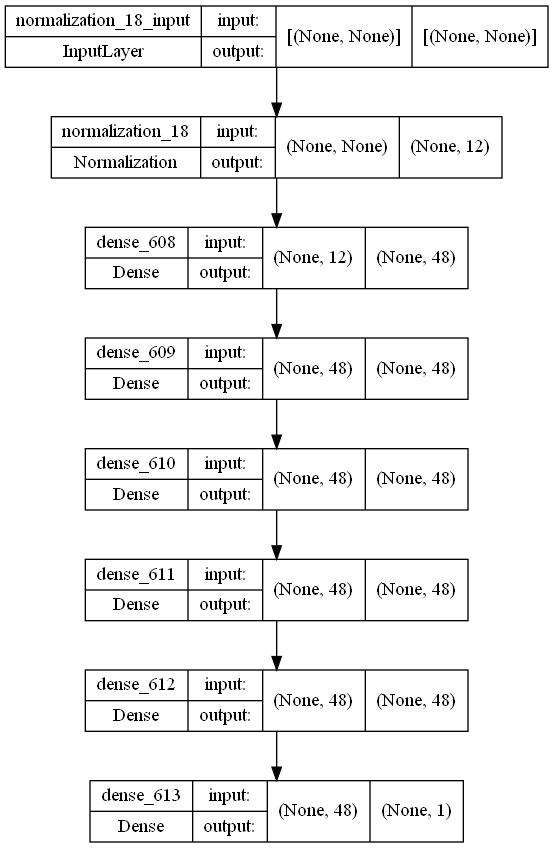

In [232]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [233]:
model.summary()

Model: "sequential_93"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_18 (Normaliza  (None, 12)               25        
 tion)                                                           
                                                                 
 dense_608 (Dense)           (None, 48)                624       
                                                                 
 dense_609 (Dense)           (None, 48)                2352      
                                                                 
 dense_610 (Dense)           (None, 48)                2352      
                                                                 
 dense_611 (Dense)           (None, 48)                2352      
                                                                 
 dense_612 (Dense)           (None, 48)                2352      
                                                     

10/10 [==============================] - 0s 1ms/step - loss: 0.9667 - mean_squared_error: 1.4511
[0.9666772484779358, 1.4510834217071533]


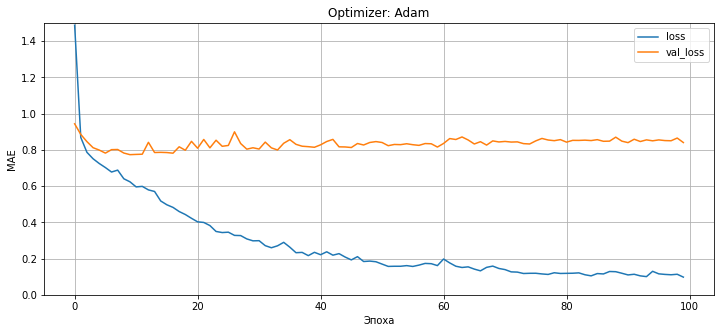

In [281]:
model = build_model()

# компиляция модели
compile_model(model, MAE, optAdam, MSE)

#  обучение модели
history = model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=100)
plot_loss(history, 'Optimizer: Adam')

# оценка
print(model.evaluate(X_test, y_test))

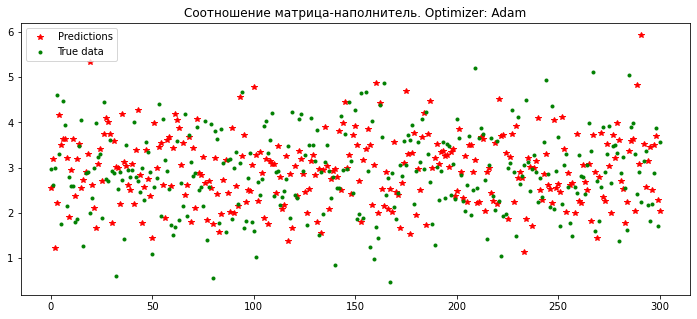

In [282]:
# предсказание
y_pred = model.predict(X_test)
plot_preds(y_test, y_pred, 'Соотношение матрица-наполнитель. Optimizer: Adam')

10/10 [==============================] - 0s 3ms/step - loss: 0.8553 - mean_squared_error: 1.1653
[0.8553369641304016, 1.1652774810791016]


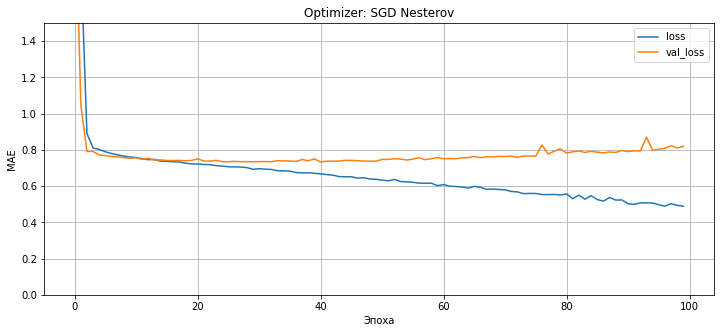

In [255]:
model = build_model()

# компиляция модели
compile_model(model, MAE, optSGD_Nesterov, MSE)

#  обучение модели
history = model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=100)
plot_loss(history, 'Optimizer: SGD Nesterov')

# оценка
print(model.evaluate(X_test, y_test))

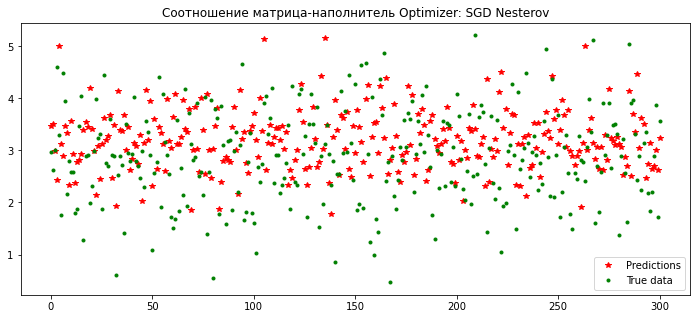

In [256]:
# предсказание
y_pred = model.predict(X_test)
plot_preds(y_test, y_pred, 'Соотношение матрица-наполнитель Optimizer: SGD Nesterov')

### Dropout

10/10 [==============================] - 0s 1ms/step - loss: 0.7492 - mean_squared_error: 0.8766
[0.7492131590843201, 0.8766104578971863]


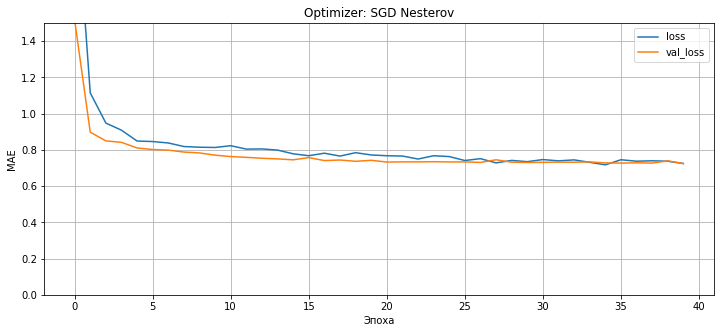

In [276]:
# стуктура модели с дропаут слоем
model = keras.Sequential([
                          normalizer,
                          layers.Dense(48, activation='relu'),
                          layers.Dropout(0.03),    
                          layers.Dense(48, activation='relu'),
                          layers.Dropout(0.03),        
                          layers.Dense(48, activation='relu'),
                          layers.Dropout(0.03),        
                          layers.Dense(48, activation='relu'),
                          layers.Dropout(0.03),        
                          layers.Dense(48, activation='relu'),    
                          layers.Dropout(0.03),        
                          layers.Dense(1, activation='linear')    
                        ])

# компиляция модели
model.compile(
              loss=MAE,
              optimizer=optSGD_Nesterov,
              metrics=MSE
              )

#  обучение модели
history = model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=40)
plot_loss(history, 'Optimizer: SGD Nesterov')

# оценка
print(model.evaluate(X_test, y_test))

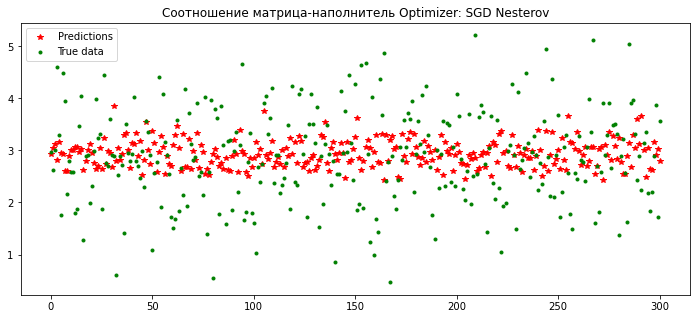

In [277]:
# предсказание
y_pred = model.predict(X_test)
plot_preds(y_test, y_pred, 'Соотношение матрица-наполнитель Optimizer: SGD Nesterov')

10/10 [==============================] - 0s 1ms/step - loss: 0.7992 - mean_squared_error: 0.9865
[0.7991747260093689, 0.9864964485168457]


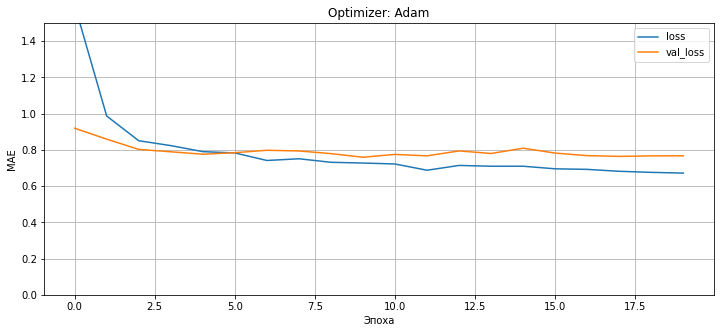

In [293]:
# стуктура модели с дропаут слоем
model = keras.Sequential([
                          normalizer,
                          layers.Dense(48, activation='relu'),
                          layers.Dropout(0.07),    
                          layers.Dense(48, activation='relu'),
                          layers.Dropout(0.07),        
                          layers.Dense(48, activation='relu'),
                          layers.Dropout(0.07),        
                          layers.Dense(48, activation='relu'),
                          layers.Dropout(0.07),        
                          layers.Dense(48, activation='relu'),    
                          layers.Dropout(0.07),        
                          layers.Dense(1, activation='linear')    
                        ])

# компиляция модели
model.compile(
              loss=MAE,
              optimizer=optAdam,
              metrics=MSE
              )

#  обучение модели
history = model.fit(X_train, y_train, validation_split=0.2, verbose=0, epochs=20)
plot_loss(history, 'Optimizer: Adam')

# оценка
print(model.evaluate(X_test, y_test))

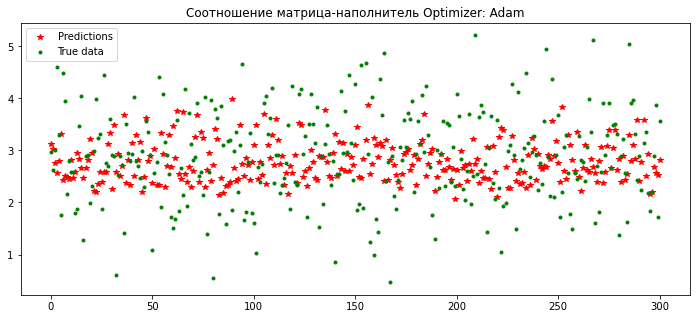

In [294]:
# предсказание
y_pred = model.predict(X_test)
plot_preds(y_test, y_pred, 'Соотношение матрица-наполнитель Optimizer: Adam')

### EarlyStopping

10/10 [==============================] - 0s 1ms/step - loss: 0.7755 - mean_squared_error: 0.9289
[0.7755177021026611, 0.9289268851280212]


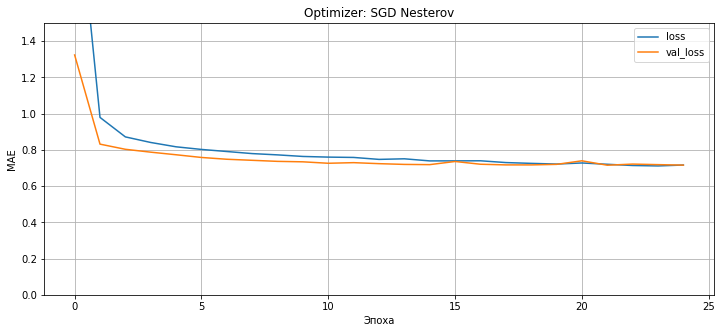

In [300]:
model = build_model()

# компиляция модели
compile_model(model, MAE, optSGD_Nesterov, MSE)

#  обучение модели
history = model.fit(
                    X_train, 
                    y_train, 
                    epochs=500, 
                    validation_split=0.2, 
                    verbose=0,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
                    )
plot_loss(history, 'Optimizer: SGD Nesterov')

# оценка
print(model.evaluate(X_test, y_test))

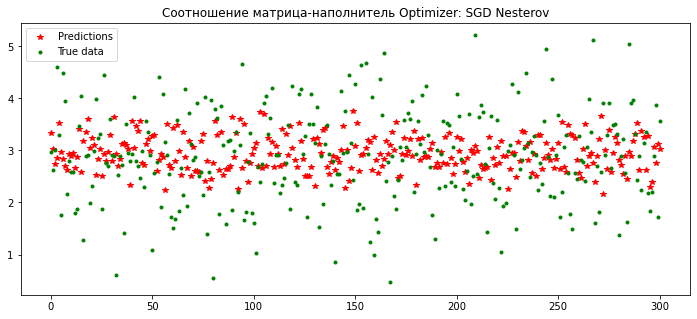

In [301]:
# предсказание
y_pred = model.predict(X_test)
plot_preds(y_test, y_pred, 'Соотношение матрица-наполнитель Optimizer: SGD Nesterov')

### Сохранение модели

In [302]:
model.save("models/model")

INFO:tensorflow:Assets written to: models/model\assets
